In [1]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_component import *
from model_utlis import *
from calculate_cluster import *
from draw_cluster import *
from relation_evaluation import *
from data_processing import *
from logger import *

In [2]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/22_10_10')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad

data = 'BMMC'
number = '4'

sc_data = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/openproblems_neurips2021/GSE194122_openproblems_neurips2021_multiome_BMMC_count.h5ad')
ATAC_data = sc_data[:, 13431:]
RNA_data = sc_data[:, 0:13431]
del sc_data
gc.collect()


In [3]:
from split_datasets import *
id_list = bmmc_batch_split_dataset(RNA_data, ATAC_data)
train_id, validation_id, test_id = id_list[int(number) - 1]
train_id_r = train_id.copy()
train_id_a = train_id.copy()
validation_id_r = validation_id.copy()
validation_id_a = validation_id.copy()
test_id_r = test_id.copy()
test_id_a = test_id.copy()

# basic multiVI

In [4]:
from scvi_colab import install
import pandas as pd
install()
import scvi
import sys
from calculate_cluster import *
import scipy.sparse as sp
from split_datasets import *

                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
Global seed set to 0


In [5]:
import scanpy as sc
import anndata as ad
import episcanpy as epi
import sklearn
from sklearn import metrics


def calculate_cluster_index1(adata):
    """
    Evaluation of cluster index of prediction. 
    Cluster method have two types:  Leiden
                         Louvain. 
    Index have eight types:   Adjusted Rand Index
                      Rand Index
                      Normalized Mutual Information
                      Adjusted Mutual Information
                      Homogeneity
                      Completeness
                      V-measure
                      Fowlkes-Mallows Scores
    
    Parameters
    ----------
    adata
        Anndata need to calculate, it's worth noting that there should be 'cell_type' in adata.obs.
        
    """  
    sc.tl.leiden(adata)

    ARI_leiden = metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden'])
    AMI_leiden = metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    NMI_leiden = metrics.normalized_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    HOM_leiden = metrics.homogeneity_score(adata.obs['cell_type'], adata.obs['leiden'])
    COM_leiden = metrics.completeness_score(adata.obs['cell_type'], adata.obs['leiden'])
    V_measure_leiden = metrics.v_measure_score(adata.obs['cell_type'], adata.obs['leiden'])
    
    return ARI_leiden, AMI_leiden, NMI_leiden, HOM_leiden, COM_leiden, V_measure_leiden

# R2A + R origin

In [6]:
file_path = '/home/atac2rna/data/atac2rna/model_output/22_10_12/debug'

In [7]:
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
    )
ATAC_data, divide_title, multiply_title, max_temp = ATAC_data_preprocessing(
    ATAC_data,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
)

1


2
3


In [9]:
import anndata as ad
R_origin_test = ad.AnnData(X=RNA_data.X[test_id_r, :])
R_origin_test.obs = RNA_data.obs.iloc[test_id_r, :]
R_origin_test.var = RNA_data.var
A_origin_test = ad.AnnData(X=ATAC_data.X[test_id_a, :])
A_origin_test.obs = ATAC_data.obs.iloc[test_id_a, :]
A_origin_test.var = ATAC_data.var

In [10]:
A_origin_test.X = inverse_TFIDF(A_origin_test, divide_title[:, test_id_a], multiply_title[:, test_id_a], max_temp)

In [11]:
del divide_title, multiply_title
import gc
gc.collect()

1003

In [12]:
adata = ad.AnnData(sp.hstack((R_origin_test.X, A_origin_test.X)))
adata.X = adata.X.tocsr()
adata.obs = R_origin_test.obs

m = len(R_origin_test.var.index)
n = len(A_origin_test.var.index)
adata.var.index = pd.Series([R_origin_test.var.index[i] if i<m else A_origin_test.var.index[i-m] for i in range(m+n)], dtype='object')
adata.var['modality'] = pd.Series(['Gene Expression' if i<m else 'Peaks' for i in range(m+n)], dtype='object').values

adata.var_names_make_unique()

adata_mvi = scvi.data.organize_multiome_anndatas(adata)

adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()

scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality')

mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)

In [15]:
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 22224  │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 104070 │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [ ]:
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 1/500:   0%|                                                                                                                                                                          | 0/500 [00:00<?, ?it/s]

Epoch 2/500:   0%|▎                                                                                                                                       | 1/500 [00:16<2:19:54, 16.82s/it, loss=7.07e+03, v_num=1]

Epoch 3/500:   0%|▌                                                                                                                                       | 2/500 [00:32<2:14:26, 16.20s/it, loss=6.78e+03, v_num=1]

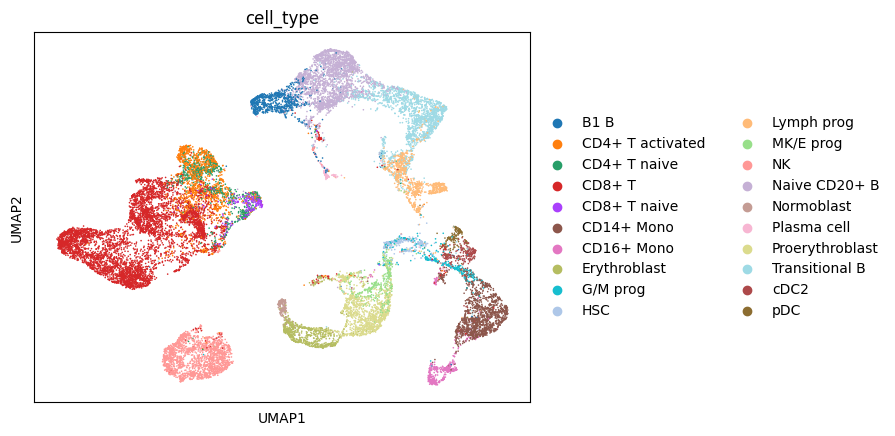

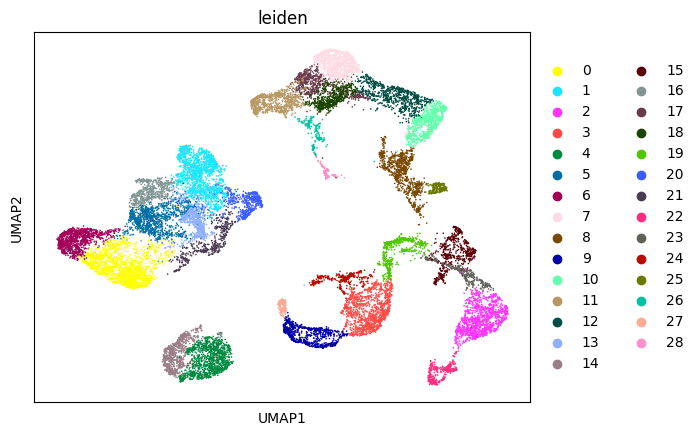

(0.4091280588237267,
 0.7133982219228441,
 0.7146121733728824,
 0.8095056904839504,
 0.6396319412671254,
 0.7146121733728824)

In [16]:
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color='cell_type', title='cell_type')
sc.tl.leiden(adata_mvi)
sc.pl.umap(adata_mvi, color='leiden', title='leiden')
calculate_cluster_index1(adata_mvi)